In [1]:
#!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def loadData():
    with np.load('/content/drive/MyDrive/ece421/assignments/a1/notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


# **-----Part 1 : Logisitc Regression With Numpy-----**

### **Start of Part 1.1: Loss Function and Gradient [8 points]**

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(W, b, x, y, reg):
    N,d = x.shape
    y_hat = sigmoid(x.dot(W) + b)
    y_hat = np.expand_dims(y_hat, axis = 1)
    y = np.expand_dims(y, axis=1)
    instance = -np.multiply(y, np.log(y_hat)) - np.multiply((1-y), np.log(1-y_hat))
    L_CE =  np.mean(instance,axis =0)
    L_w = (reg / 2.0) * (np.linalg.norm(W) ** 2)
    final_loss = L_CE + L_w
    final_loss = final_loss.astype(np.float) 
    return final_loss


In [5]:
def grad_loss(W, b, x, y, reg):
    N, d = x.shape
    h = sigmoid(x.dot(W) + b)
    w_grad = (1.0/N)*(np.dot( x.T, h-y)) + reg * W
    b_grad = (1.0/N) * sum( h - y)
    return w_grad, b_grad

Testing Loss function and Gradient

In [6]:
data = loadData()
W = np.random.rand(28 * 28, 1)
#print(W)
W = W /sum(W)
#print(W)
b = np.random.normal(0,1,1)
x= data[0]
y = data[3]
#print("x size {}".format(x.shape))
#print("y size {}".format(y.shape))
x = np.reshape(x, (3500, -1))
y = y.reshape(-1)

for i in range(10):
  print(loss(W, i, x, y, 2))


[[0.89103559]
 [0.53530266]
 [0.53530266]
 ...
 [0.89103559]
 [0.53530266]
 [0.89103559]]
[[1.5884801 ]
 [0.23274716]
 [0.23274716]
 ...
 [1.5884801 ]
 [0.23274716]
 [1.5884801 ]]
[[2.44884707]
 [0.09311414]
 [0.09311414]
 ...
 [2.44884707]
 [0.09311414]
 [2.44884707]]
[[3.39204929]
 [0.03631635]
 [0.03631635]
 ...
 [3.39204929]
 [0.03631635]
 [3.39204929]]
[[4.37029944]
 [0.0145665 ]
 [0.0145665 ]
 ...
 [4.37029944]
 [0.0145665 ]
 [4.37029944]]
[[5.36217522]
 [0.00644229]
 [0.00644229]
 ...
 [5.36217522]
 [0.00644229]
 [5.36217522]]
[[6.35916948e+00]
 [3.43654217e-03]
 [3.43654217e-03]
 ...
 [6.35916948e+00]
 [3.43654217e-03]
 [6.35916948e+00]]
[[7.35806140e+00]
 [2.32846732e-03]
 [2.32846732e-03]
 ...
 [7.35806140e+00]
 [2.32846732e-03]
 [7.35806140e+00]]
[[8.35765345e+00]
 [1.92051409e-03]
 [1.92051409e-03]
 ...
 [8.35765345e+00]
 [1.92051409e-03]
 [8.35765345e+00]]
[[9.35750333e+00]
 [1.77039376e-03]
 [1.77039376e-03]
 ...
 [9.35750333e+00]
 [1.77039376e-03]
 [9.35750333e+00]]


### **End of Part 1.1: Loss Function and Gradient [8 points]**

### **Start of Part 1.2: Gradient Descent Implemenation [6 points]**


In [7]:
def predictions(w,b,x):
    z = np.dot(x,w) + b
    output = np.ones(z.shape)
    neg = np.where(z < 0)
    output[neg] = z[neg] * 0
    return output

def evaluate(pred, label):
    N = np.shape(pred)[0]
    wrong = np.sum(np.absolute(pred - label))
    correct = N - wrong
    return correct / N



def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, valid_x, valid_y, test_x, test_y,part):
    
    max = 0
    cnt  = 0
    #Plotting lists
    loss_list = [0] * epochs
    valid_loss_list = [0] * epochs
    test_loss_list = [0] * epochs
    acc_list = [0] * epochs
    valid_acc_list = [0] * epochs
    test_acc_list = [0] * epochs
    #Reshaping if inputs are messed up and not formatted correctly

    y = y.reshape(-1)
    valid_y = valid_y.reshape(-1)
    test_y = test_y.reshape(-1)
    x = np.reshape(x, (3500, -1))
    valid_x = np.reshape(valid_x, (100, -1))
    test_x = np.reshape(test_x, (145, -1))
    for e in range(0,epochs):
      gradient_w, gradient_bias = grad_loss(W,b,x,y,reg)

      training_loss = loss(W, b, x, y, reg)[0]
      loss_t = float(0.0 + training_loss)


      valid_loss = loss(W, b, valid_x, valid_y, reg)
      loss_v = float(0.0 + valid_loss)

      test_loss = loss(W, b, test_x, test_y, reg)
      loss_test = float(0.0 + test_loss)

      w_old = W
      new_w = W - alpha * gradient_w 
      new_b = b - alpha * gradient_bias
      new_loss = loss(new_w, new_b,x,y,reg)
      #Getting predictions
      y_hat = predictions(W, b, x)
      y_hat_valid = predictions(W, b, valid_x)
      y_hat_test = predictions(W, b, test_x)
      #Getting accuracies by evaluation functions
      acc = evaluate(y_hat,y)
      acc_valid = evaluate(y_hat_valid,valid_y)
      acc_test = evaluate(y_hat_test,test_y)
      if acc > max:
            max = acc
      #print("Epoch : {}".format(e))
      #print("Old Loss: %f \tNewloss: %f" % (training_loss, new_loss))
      #print("Accuracy: %f \tLoss: %f" % ( acc, new_loss))
      diff = np.sum(np.absolute((W -new_w)))
      if np.linalg.norm(new_w - w_old) > error_tol :
            W = new_w
            b = new_b
            cnt = cnt +1
      else:
        break

      loss_list[e] = loss_t
      test_loss_list[e] = loss_v
      valid_loss_list[e] = loss_test

      valid_acc_list[e] = acc_valid
      test_acc_list[e] = acc_test
      acc_list[e] = acc
    print("Best accuracy: %d" % (max))
    epoch_list = np.arange(1,cnt+1,1)
    if part == "all":
      plot_loss(epoch_list, loss_list, valid_loss_list ,test_loss_list, reg, alpha,"all")
      plot_acc(epoch_list, acc_list, valid_acc_list, test_acc_list,reg, alpha,"all")
    if part == "t+v":
      plot_loss(epoch_list, loss_list, valid_loss_list ,test_loss_list, reg, alpha,"t+v")
      plot_acc(epoch_list, acc_list, valid_acc_list, test_acc_list,reg, alpha,"t+v")


    return W,b


def plot_loss(epoch, loss, vl ,tl,reg, alpha,typep):
    plt.figure(figsize=(20,5))
    plt.plot()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot for logisitc regression with regularizer(lambda) = {} and learning rate = {} '.format(reg,alpha))
    plt.plot(epoch, loss)
    plt.plot(epoch, vl)
    if typep =="all":
      plt.plot(epoch, tl)
      plt.legend(["Training", "Validation", "Testing"])
    if typep == "t+v":
      plt.legend(["Training", "Validation"])
    print("Final training loss: %f \tFinal Validation loss: %f \tFinal Test loss: %f " % (loss[-1], vl[-1], tl[-1]))
    plt.show()

def plot_acc(epoch, acc, va, ta, reg, alpha,typep):
    plt.figure(figsize=(20,5))
    plt.plot()
    plt.xlabel(' Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plot for logisitc regression with regularizer(lambda) = {} and learning rate = {} '.format(reg,alpha))
    plt.plot(epoch, acc)
    plt.plot(epoch, va)
    if typep =="all":
      plt.plot(epoch, ta)
      plt.legend(["Training", "Validation", "Testing"])
    if typep == "t+v":
      plt.legend(["Training", "Validation"])
    print("Final training acc: %f \tFinal Validation acc: %f \tFinal Test acc: %f" %(acc[-1],va[-1],ta[-1]))
    plt.show()

testing of gradient descent

Best accuracy: 0
Final training loss: 0.246277 	Final Validation loss: 0.243155 	Final Test loss: 0.268730 


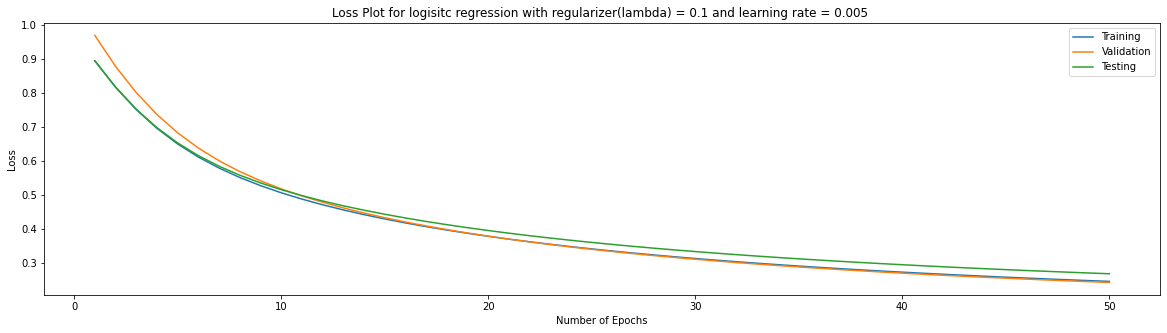

Final training acc: 0.940286 	Final Validation acc: 0.930000 	Final Test acc: 0.924138


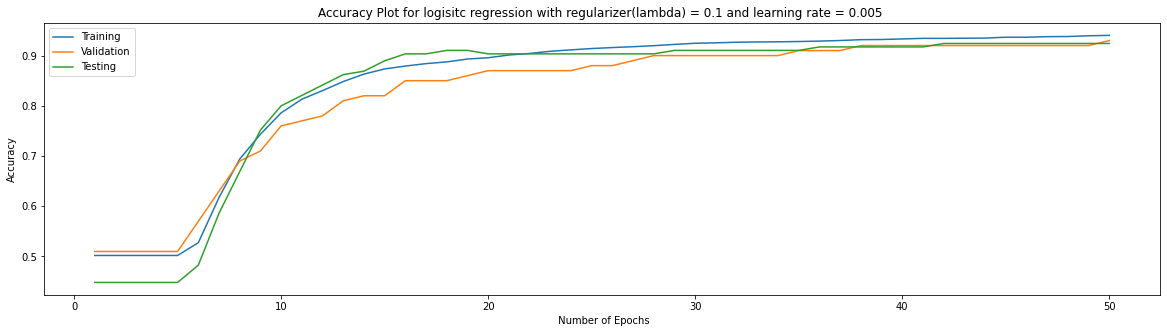

In [8]:
 data = loadData()
W = np.random.rand(28 * 28)
W = W /sum(W)
b = np.random.normal(0,1,1)
x= data[0]
y = data[3]
w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.005,50,0.1,1*10**(-7),data[1],data[4],data[2],data[5],"all")

### **End of Part 1.2: Gradient Descent Implementation [6 points]**

Start of Part 1.3: Tuning the Learning Rate [3 points]

Best accuracy: 0
Final training loss: 0.056073 	Final Validation loss: 0.081045 	Final Test loss: 0.060871 


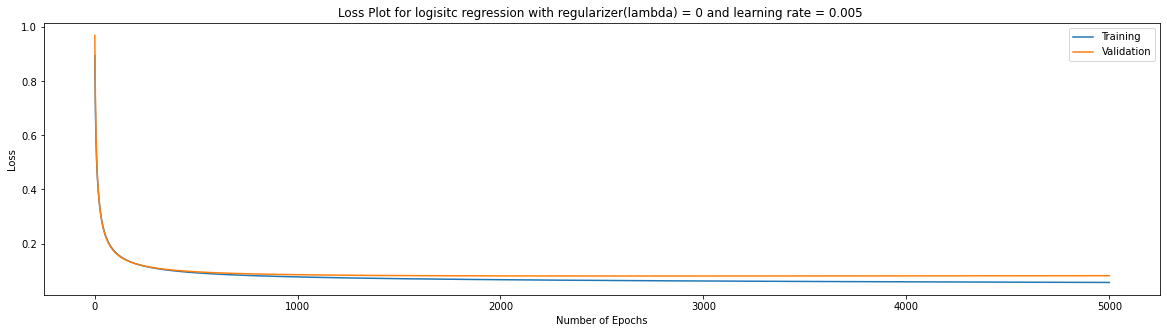

Final training acc: 0.983143 	Final Validation acc: 0.980000 	Final Test acc: 0.979310


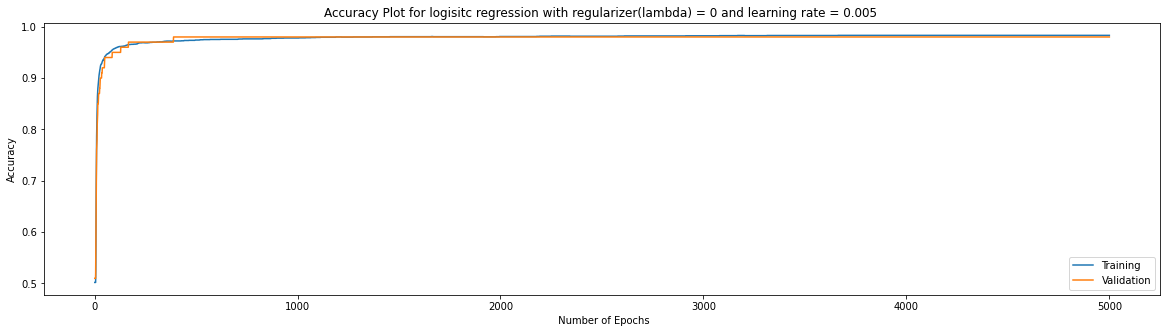

Best accuracy: 0
Final training loss: 0.076494 	Final Validation loss: 0.084607 	Final Test loss: 0.086320 


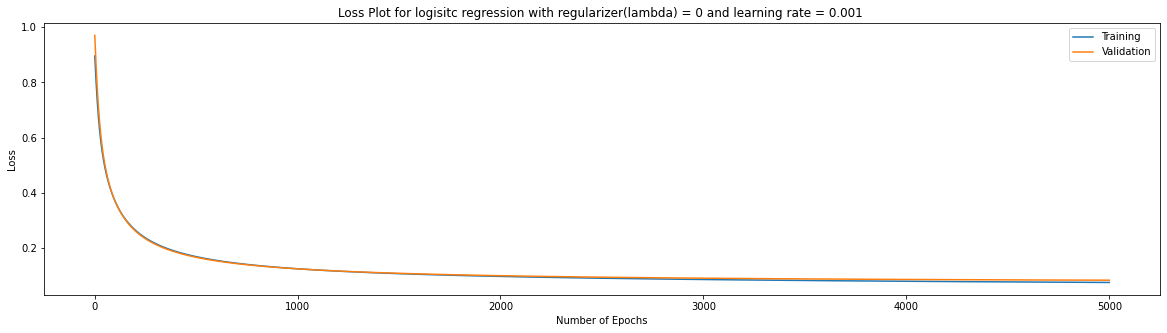

Final training acc: 0.978000 	Final Validation acc: 0.980000 	Final Test acc: 0.965517


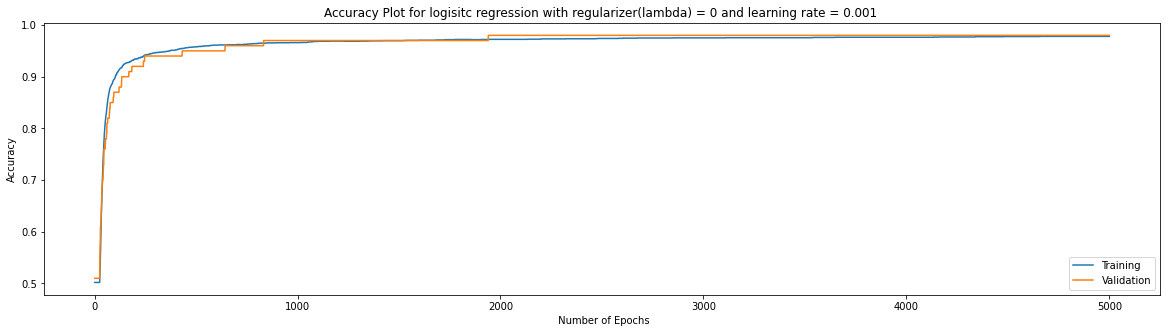

Best accuracy: 0
Final training loss: 0.169821 	Final Validation loss: 0.167475 	Final Test loss: 0.191365 


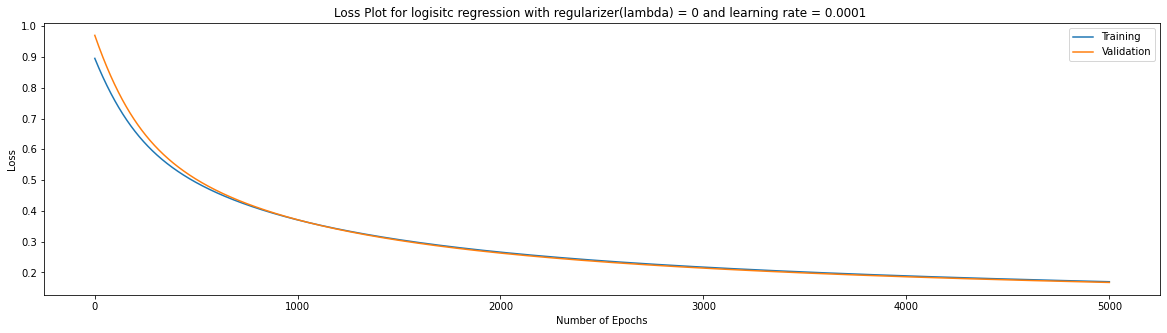

Final training acc: 0.957714 	Final Validation acc: 0.950000 	Final Test acc: 0.972414


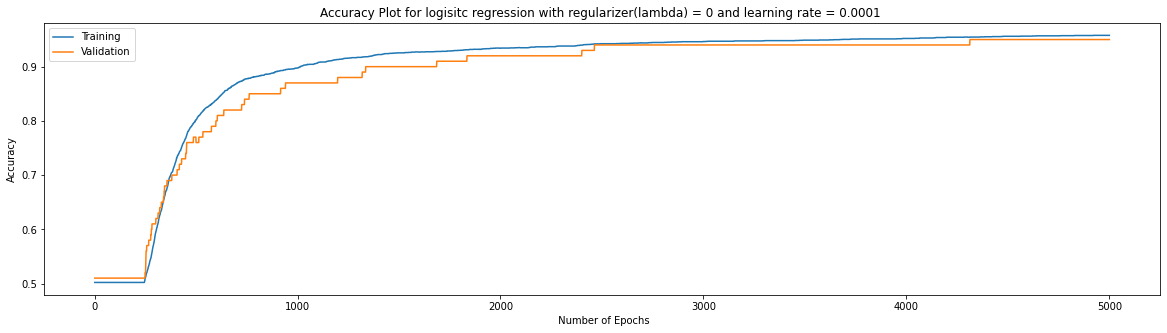

In [9]:
data = loadData()
W = np.random.rand(28 * 28)
W = W /sum(W)
b = np.random.normal(0,1,1)


#Plot the training and validation loss vs epochs for l.r = {0.005,0.001, 0.0001}
#Plot the training and validation accuracy vs epochs for l.r = {0.005,0.001, 0.0001}
w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.005,5000,0,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")

w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.001,5000,0,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")

w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.0001,5000,0,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")




End of Part 1.3: Tuning the Learning Rate [3 points]

Start of Part 1.4: Generalization [3 points]

Best accuracy: 0
Final training loss: 0.057357 	Final Validation loss: 0.081976 	Final Test loss: 0.062261 


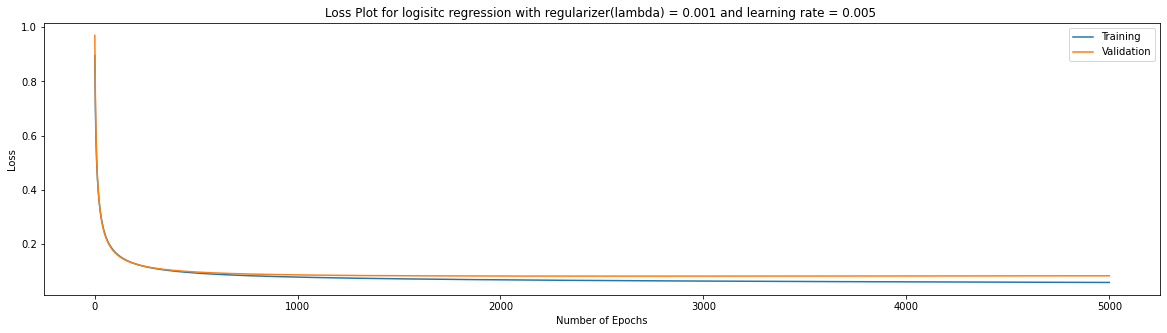

Final training acc: 0.983143 	Final Validation acc: 0.980000 	Final Test acc: 0.979310


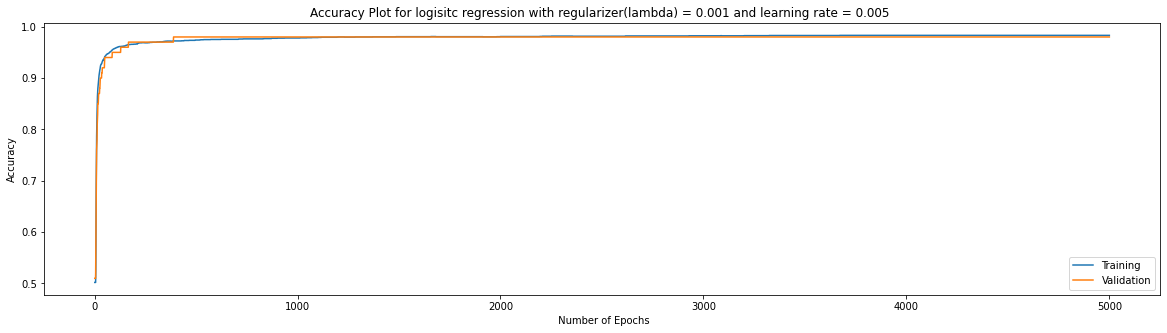

Best accuracy: 0
Final training loss: 0.118995 	Final Validation loss: 0.128329 	Final Test loss: 0.130376 


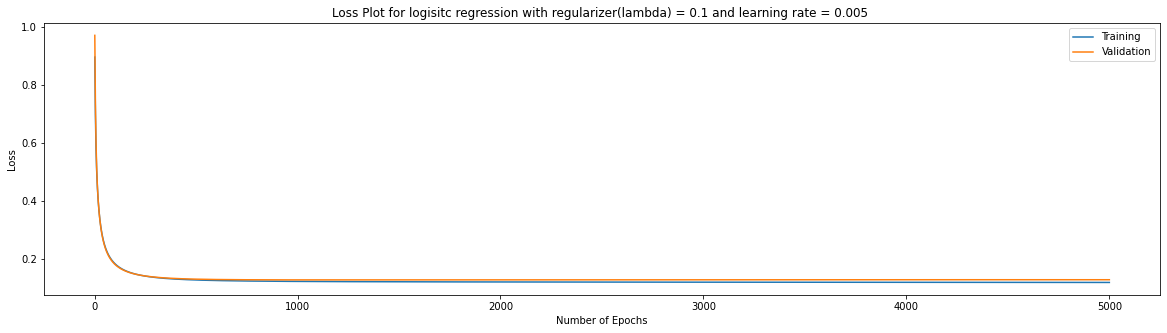

Final training acc: 0.980571 	Final Validation acc: 0.980000 	Final Test acc: 0.965517


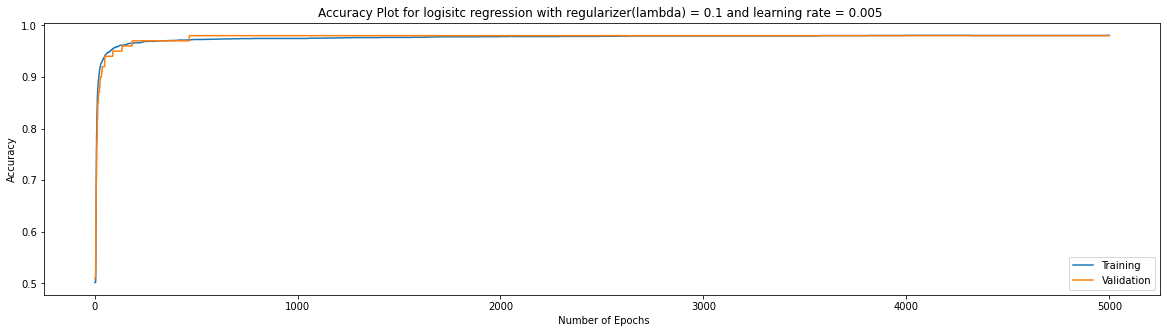

Best accuracy: 0
Final training loss: 0.203960 	Final Validation loss: 0.205740 	Final Test loss: 0.221822 


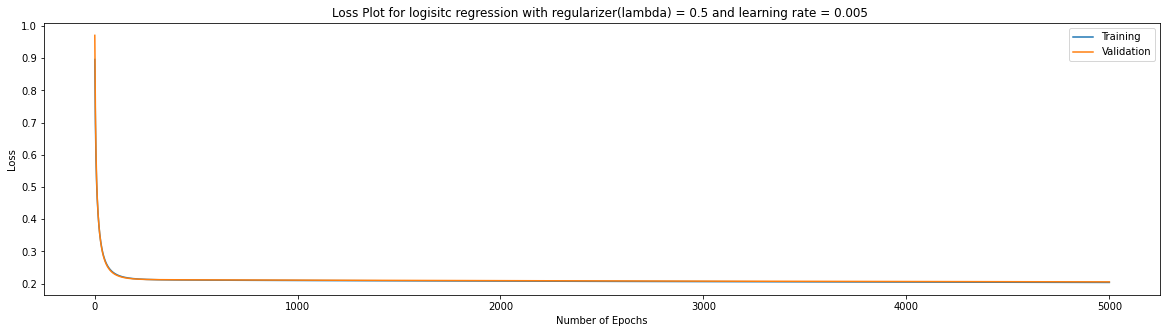

Final training acc: 0.974286 	Final Validation acc: 0.980000 	Final Test acc: 0.965517


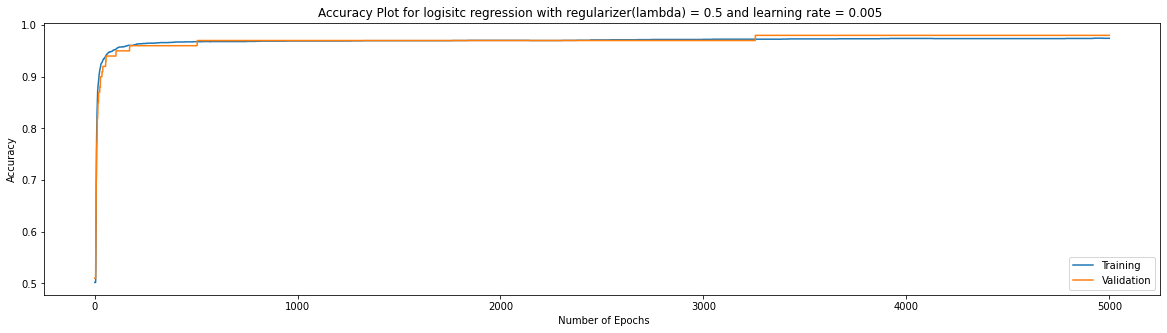

In [10]:
#Plot the training and validation loss vs epochs for lambda = {0.001, 0.1, 0.5} and lr = 0.005
#Plot the training and validation accuracy vs epochs for lambda = {0.001, 0.1 0.5} and lr =0.005


w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.005,5000,0.001,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")

w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.005,5000,0.1,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")

w_opt, b_opt = grad_descent(W,b,data[0],data[3],0.005,5000,0.5,1*10**(-7),data[1],data[4],data[2],data[5],"t+v")



End of Part 1.4: Generalization [3 points]


# **-----Part 2 : Logisitc Regression in TensorFlow-----**

Start of Part 2.1: Building the Computational Graph [5 points]

In [11]:
def buildgraph():
    np.random.seed(421)
    w = tf.Variable(tf.truncated_normal(shape=(784, 1), stddev=0.5, dtype=tf.float32))
    b = tf.Variable(0.0)
    X_data = tf.placeholder(tf.float32, shape=(None, 784))
    y_real = tf.placeholder(tf.float32, shape=(None, 1))
    reg = tf.placeholder(tf.float32, shape=())
    y_pred = tf.add(tf.matmul(X_data, w), b)
    loss = tf.losses.sigmoid_cross_entropy(y_real, y_pred) + reg *(1/2.0) * tf.norm(w)**2
    optimizer = tf.train.AdamOptimizer(0.001, 0.95, 0.99, 1e-08).minimize(loss)
    return w, b, y_pred, y_real, loss, optimizer

buildgraph()



AttributeError: ignored

End of Part 2.1: Building the Computational Graph [5 points]

Start of Part 2.2: Implementing Stochastic Gradient Descent [5 points] -------> REDO IN TENSORFLOW, CAN'T USE PYTROCH



In [ ]:
# np.random.seed(1)
# data = loadData()
# W = np.random.rand(28 * 28)
# W = W /sum(W)
# b = np.random.normal(0, 1, 1)
#
#
# valid_x = data[1]
# test_x = data[2]
# x = data[0]
# y = data[3]
# x_vals = np.reshape(x, (3500, -1))
# valid_x = np.reshape(valid_x, (100, -1))
# test_x = np.reshape(test_x, (145, -1))
# # SGD(700,500,0.001,loss = "MSE", opt = "GD",beta1=0.95, beta2=0.99, epsilon=1e-08,valid_x =valid_x, valid_y =data[4], test_x = test_x,test_y = data[5])

End of Part 2.2: Implementing Stochastic Gradient Descent [5 points]


Start of Part 2.3: Batch size investigation [4 points]



End of Part 2.3: Batch size investigation [4 points]


Start of Part 2.4: Hyperparameter investigation [4 points]


End of Part 2.4: Hyperparameter investigation [4 points]

Start of Part 2.4: Comparison against Batch GD[2 points]

End of Part 2.4: Comparison against Batch GD[2 points]